# Building Energy Consumption - Linear Model

## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

from eplusparser.eplusparser import parse, get_zones
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LassoLarsCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split

np.random.seed(42)

In [2]:
DATA_FILE_PATH = "../OpenStudio_Models/MediumOffice_2/run/eplusout.sql"

sim_df = parse(DATA_FILE_PATH)
zone_df = get_zones(DATA_FILE_PATH)

display(sim_df.head())
display(zone_df.head())

VariableName Cooling:Electricity Electricity:Facility  \
KeyValue                                                
TimeIndex                                               
7                            0.0         6.200931e+07   
14                           0.0         6.200931e+07   
21                           0.0         7.846241e+07   
28                           0.0         7.414914e+07   
35                           0.0         6.200931e+07   

VariableName ExteriorLights:Electricity Fans:Electricity  Gas:Facility  \
KeyValue                                                                 
TimeIndex                                                                
7                            18840654.0     0.000000e+00  4.597009e+06   
14                           18840654.0     0.000000e+00  4.597009e+06   
21                           18840654.0     3.725539e+06  4.597009e+06   
28                           18840654.0     3.104616e+06  4.597009e+06   
35                           18840654.0     0.000000e+00  4.597009e+06   

VariableName Heating:Electricity Heating:Gas InteriorEquipment:Electricity  \
KeyValue                                                                     
TimeIndex                                                                    
7                   0.000000e+00         0.0                  3.448095e+07   
14                  0.000000e+00         0.0                  3.448095e+07   
21                  1.272756e+07         0.0                  3.448095e+07   
28                  9.035210e+06         0.0                  3.448095e+07   
35                  0.000000e+00         0.0                  3.448095e+07   

VariableName InteriorLights:Electricity  \
KeyValue                                  
TimeIndex                                 
7                          8.687704e+06   
14                         8.687704e+06   
21                         8.687704e+06   
28                         8.687704e+06   
35                         8.687704e+06   

VariableName                                 People Air Temperature  ...  \
KeyValue     CORE_BOTTOM ZN OFFICE WHOLEBUILDING - MD OFFICE PEOPLE  ...   
TimeIndex                                                            ...   
7                                                           0.0      ...   
14                                                          0.0      ...   
21                                                          0.0      ...   
28                                                          0.0      ...   
35                                                          0.0      ...   

VariableName Zone Thermostat Heating Setpoint Temperature  \
KeyValue                            PERIMETER_BOT_ZN_4 ZN   
TimeIndex                                                   
7                                               12.636237   
14                                              12.668625   
21                                              12.885373   
28                                              13.033262   
35                                              12.886336   

VariableName                                              \
KeyValue     PERIMETER_MID_ZN_1 ZN PERIMETER_MID_ZN_2 ZN   
TimeIndex                                                  
7                        12.756805             14.009754   
14                       12.863584             14.006175   
21                       13.151408             14.178937   
28                       13.373711             14.299899   
35                       13.310278             14.166440   

VariableName                                              \
KeyValue     PERIMETER_MID_ZN_3 ZN PERIMETER_MID_ZN_4 ZN   
TimeIndex                                                  
7                        14.065678             13.644558   
14                       14.051729             13.687547   
21                       14.206320             13.901863   
28                       14.309835       

,ZoneName,RelNorth,OriginX,OriginY,OriginZ,CentroidX,CentroidY,CentroidZ,OfType,Multiplier,...,MaximumZ,CeilingHeight,Volume,InsideConvectionAlgo,OutsideConvectionAlgo,FloorArea,ExtGrossWallArea,ExtNetWallArea,ExtWindowArea,IsPartOfTotalArea
ZoneIndex,,,,,,,,,,,,,,,,,,,,,
1,CORE_BOTTOM ZN,0.0,0.0,0.0,0.0,24.95535,16.6369,1.3716,1,1.0,...,2.7432,2.7432,2698.037524,2,2,983.536572,0.000000,0.000000,0.0,1
2,CORE_MID ZN,0.0,0.0,0.0,0.0,24.95535,16.6369,5.3340,1,1.0,...,6.7056,2.7432,2698.037524,2,2,983.536572,0.000000,0.000000,0.0,1
3,CORE_TOP ZN,0.0,0.0,0.0,0.0,24.95535,16.6369,9.2964,1,1.0,...,10.6680,2.7432,2698.037524,2,2,983.536572,0.000000,0.000000,0.0,1
4,FIRSTFLOOR_PLENUM ZN,0.0,0.0,0.0,0.0,24.95550,16.6369,3.3528,1,1.0,...,3.9624,1.2192,2024.760348,2,2,1660.728632,202.837816,202.837816,0.0,0
5,MIDFLOOR_PLENUM ZN,0.0,0.0,0.0,0.0,24.95550,16.6369,7.3152,1,1.0,...,7.9248,1.2192,2024.760348,2,2,1660.728632,202.837816,202.837816,0.0,0


In [3]:
# Utility Functions

def plot_columns(df):
    plt.rcParams["figure.figsize"] = (18,10)
    plt.rcParams["figure.subplot.hspace"] = 0.5
    plt.rcParams["figure.subplot.wspace"] = 0.5

    _, axes = plt.subplots(math.ceil(len(df.columns)/5), 5)
    for i, column in enumerate(df):
        ax=axes[int(i/5)][i%5]
        ax.scatter(df.index,df[column])
        ax.set_title(column)

    plt.show()
    
def plot_variable(varName, df):
    plt.rcParams["figure.figsize"] = (6,4)
    ax = plt.subplot(1,1,1)
    p1, = ax.plot(df[varName])
    ax.set_xlabel("Hour")
    ax.set_ylabel(varName)
    plt.show()
    
def scale_data(df, scaler):
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

def rmse_cv(model, X, y):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

## Data Exploration

### Thermostat Control Type

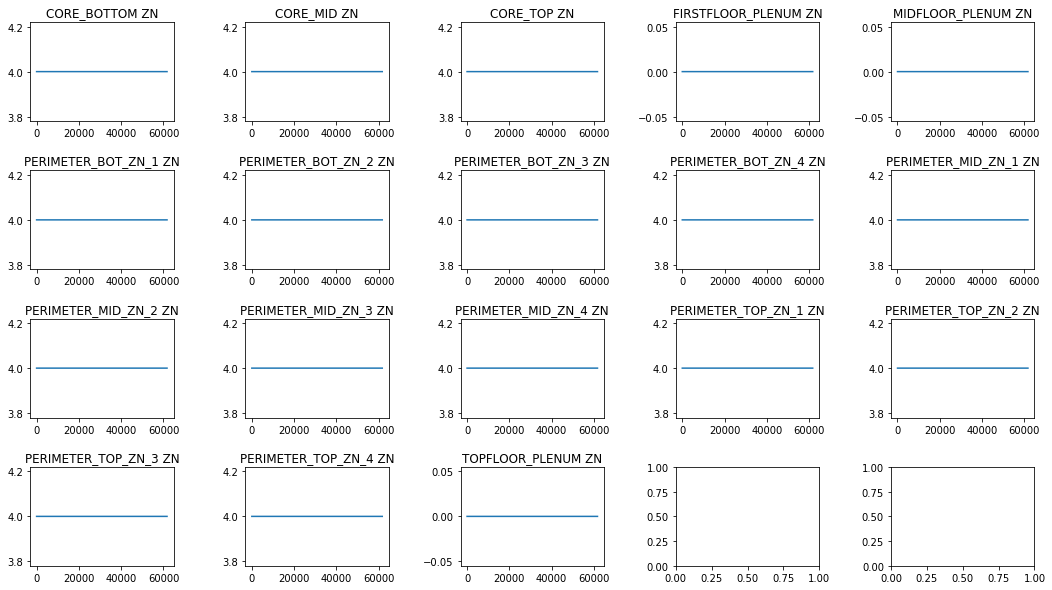

In [4]:
# Plot Thermostat control type vs Setpoints

plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams["figure.subplot.hspace"] = 0.5
plt.rcParams["figure.subplot.wspace"] = 0.5
_, axes = plt.subplots(4, 5)

for i, z in enumerate(zone_df["ZoneName"]):
    ax=axes[int(i/5)][i%5]
    ax.plot(sim_df["Zone Thermostat Control Type"][z])
    ax.set_title(z)

plt.show()

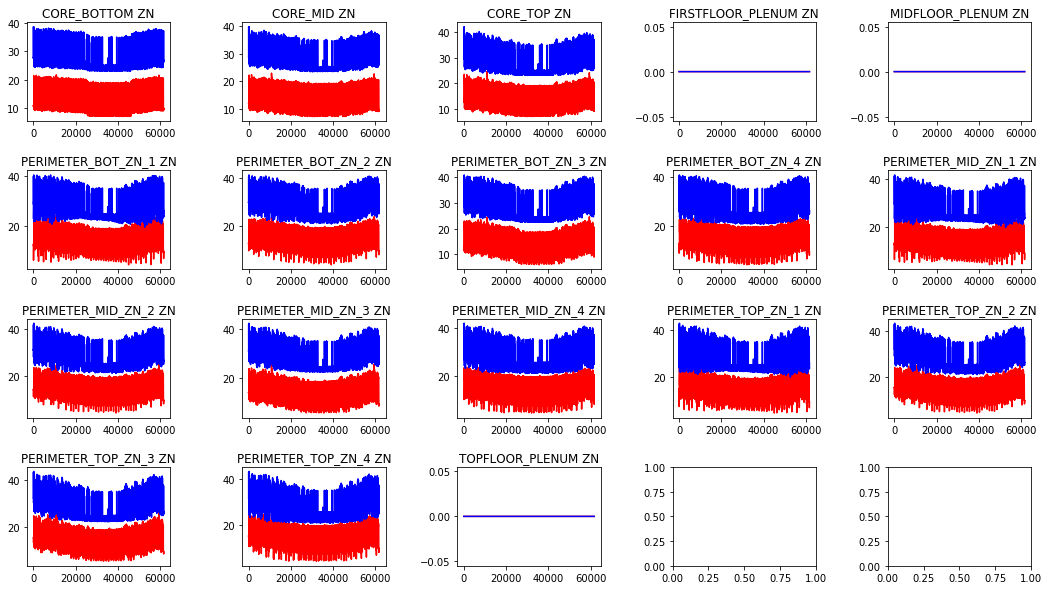

In [5]:
# Plot Thermostat setpoints in each zone
_, axes = plt.subplots(4, 5)

for i, z in enumerate(zone_df["ZoneName"]):
    ax=axes[int(i/5)][i%5]
    
    heating_setpoint = sim_df["Zone Thermostat Heating Setpoint Temperature"][z]
    cooling_setpoint = sim_df["Zone Thermostat Cooling Setpoint Temperature"][z]
    
    ax.plot(heating_setpoint, "r", cooling_setpoint, "b")
    ax.set_title(z)

plt.show()

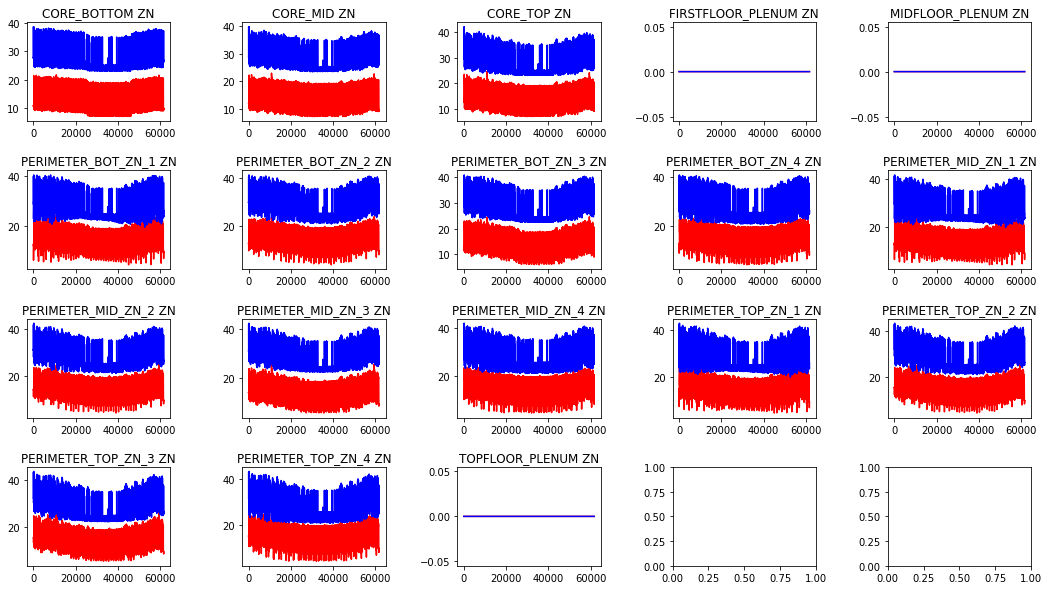

In [6]:
# Plot Thermostat setpoints in each zone
_, axes = plt.subplots(4, 5)

for i, z in enumerate(zone_df["ZoneName"]):
    ax=axes[int(i/5)][i%5]
    
    heating_setpoint = sim_df["Zone Thermostat Heating Setpoint Temperature"][z]
    cooling_setpoint = sim_df["Zone Thermostat Cooling Setpoint Temperature"][z]
    
    ax.plot(heating_setpoint, "r", cooling_setpoint, "b")
    ax.set_title(z)

plt.show()

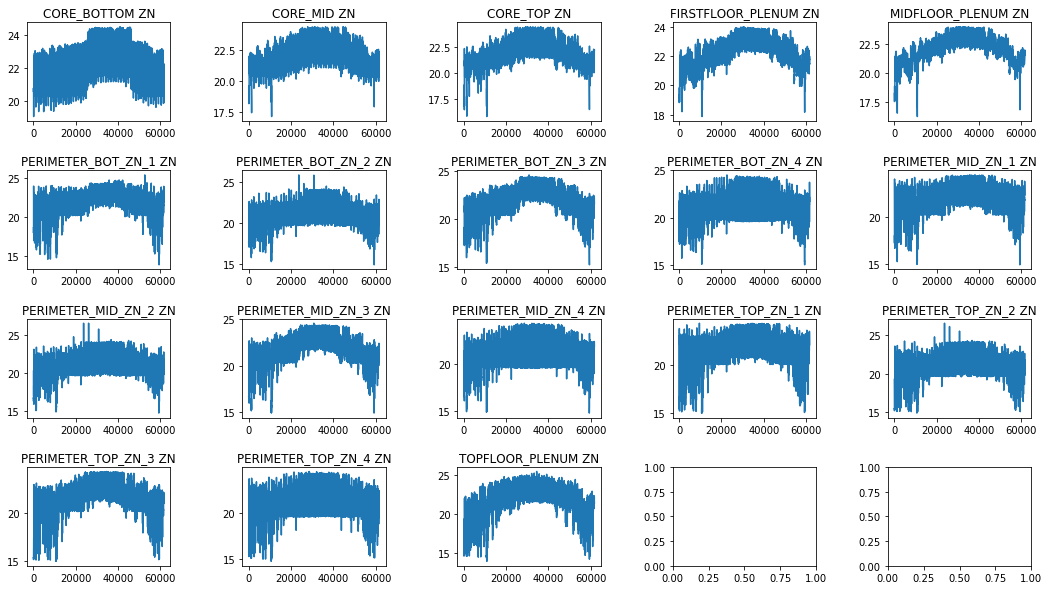

In [7]:
# Plot zone temps
_, axes = plt.subplots(4, 5)

for i, z in enumerate(zone_df["ZoneName"]):
    ax=axes[int(i/5)][i%5]
    
    temps = sim_df["Zone Air Temperature"][z]
    ax.plot(temps)
    ax.set_title(z)

plt.show()

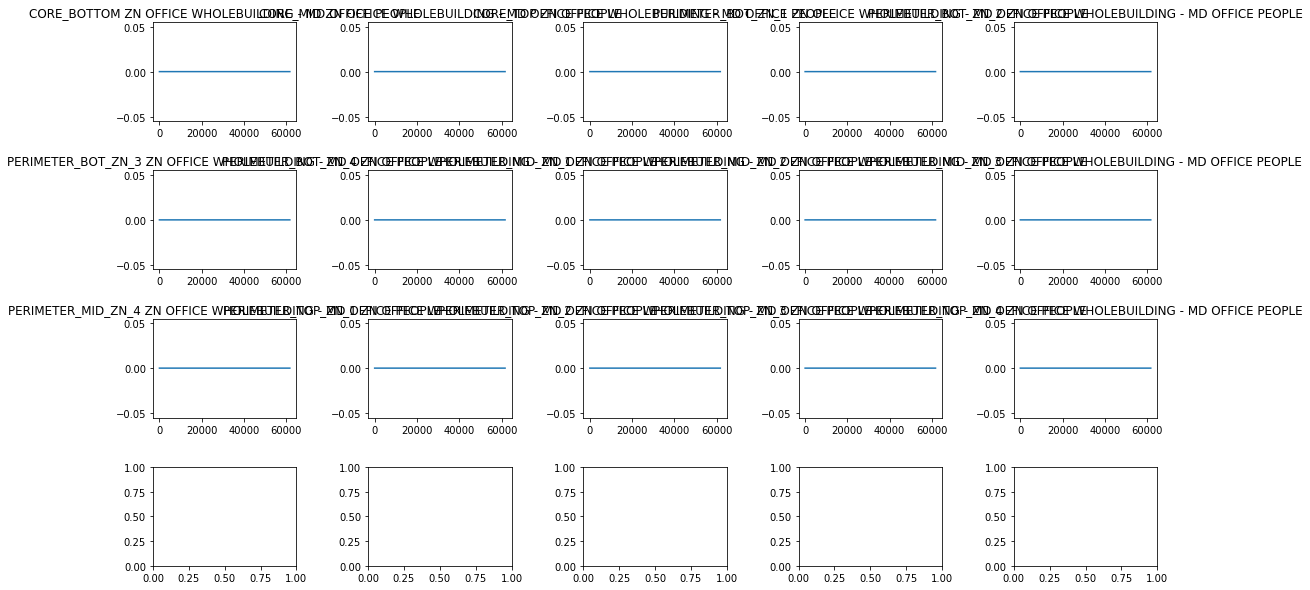

In [9]:
# Plot zone temps
_, axes = plt.subplots(4, 5)

for i, z in enumerate(sim_df["People Air Temperature"]):
    ax=axes[int(i/5)][i%5]
    
    temps = sim_df["People Air Temperature"][z]
    ax.plot(temps)
    ax.set_title(z)

plt.show()

### Averaged Feature Plots

In [12]:
# Filter out all schedules except those starting with OFFICEMEDIUM (these are the only ones changing)
df_sched = sim_df['Schedule Value'].filter(regex='OFFICEMEDIUM.*', axis=1)

In [13]:
df_zone = sim_df.copy()
del df_zone['Schedule Value']

# Filter out Plenum zones because they don't have control inputs
df_zone = df_zone.drop(df_zone.filter(regex='.*_PLENUM ZN').columns, axis=1)

# TODO: Figure out how to weight each zone by volume

# Average multi-index by zones
df_zone.columns = df_zone.columns.get_level_values(0)
df_zone = df_zone.groupby(lambda x:x, axis=1).mean()

df_mean = df_zone.join(df_sched)
df_mean.head()

,Cooling:Electricity,Electricity:Facility,ExteriorLights:Electricity,Fans:Electricity,Gas:Facility,Heating:Electricity,Heating:Gas,InteriorEquipment:Electricity,InteriorLights:Electricity,People Air Temperature,...,OFFICEMEDIUM BLDG_SWH_SCH,OFFICEMEDIUM CLGSETP_SCH_NO_SETBACK,OFFICEMEDIUM ELEV_LIGHT_FAN_SCH_ADD_DF,OFFICEMEDIUM EXTERIOR_LIGHTING_SCHEDULE_A,OFFICEMEDIUM EXTERIOR_LIGHTING_SCHEDULE_B,OFFICEMEDIUM HTGSETP_SCH_PACU_VAV_BOT,OFFICEMEDIUM HVACOPERATIONSCHD,OFFICEMEDIUM INFIL_DOOR_OPENING_SCH,OFFICEMEDIUM INFIL_SCH_PNNL,OFFICEMEDIUM MINOA_MOTORIZEDDAMPER_SCHED
TimeIndex,,,,,,,,,,,,,,,,,,,,,
7,0.0,6.200931e+07,18840654.0,0.000000e+00,4.597009e+06,0.000000e+00,0.0,3.448095e+07,8.687704e+06,0.0,...,0.0,24.0,0.0,0.0,0.7,15.6,0.0,0.0,1.0,0.0
14,0.0,6.200931e+07,18840654.0,0.000000e+00,4.597009e+06,0.000000e+00,0.0,3.448095e+07,8.687704e+06,0.0,...,0.0,24.0,0.0,0.0,0.7,15.6,0.0,0.0,1.0,0.0
21,0.0,7.846241e+07,18840654.0,3.725539e+06,4.597009e+06,1.272756e+07,0.0,3.448095e+07,8.687704e+06,0.0,...,0.0,24.0,0.0,0.0,0.7,15.6,0.0,0.0,1.0,0.0
28,0.0,7.414914e+07,18840654.0,3.104616e+06,4.597009e+06,9.035210e+06,0.0,3.448095e+07,8.687704e+06,0.0,...,0.0,24.0,0.0,0.0,0.7,15.6,0.0,0.0,1.0,0.0
35,0.0,6.200931e+07,18840654.0,0.000000e+00,4.597009e+06,0.000000e+00,0.0,3.448095e+07,8.687704e+06,0.0,...,0.0,24.0,0.0,0.0,0.7,15.6,0.0,0.0,1.0,0.0


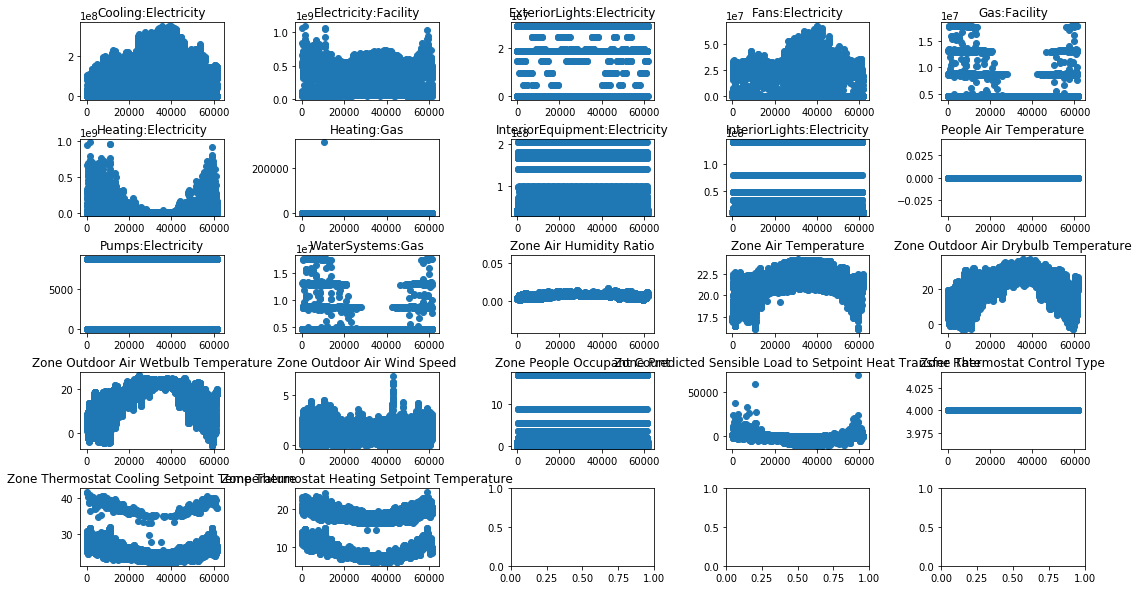

In [14]:
plot_columns(df_zone)

### Schedule Plots

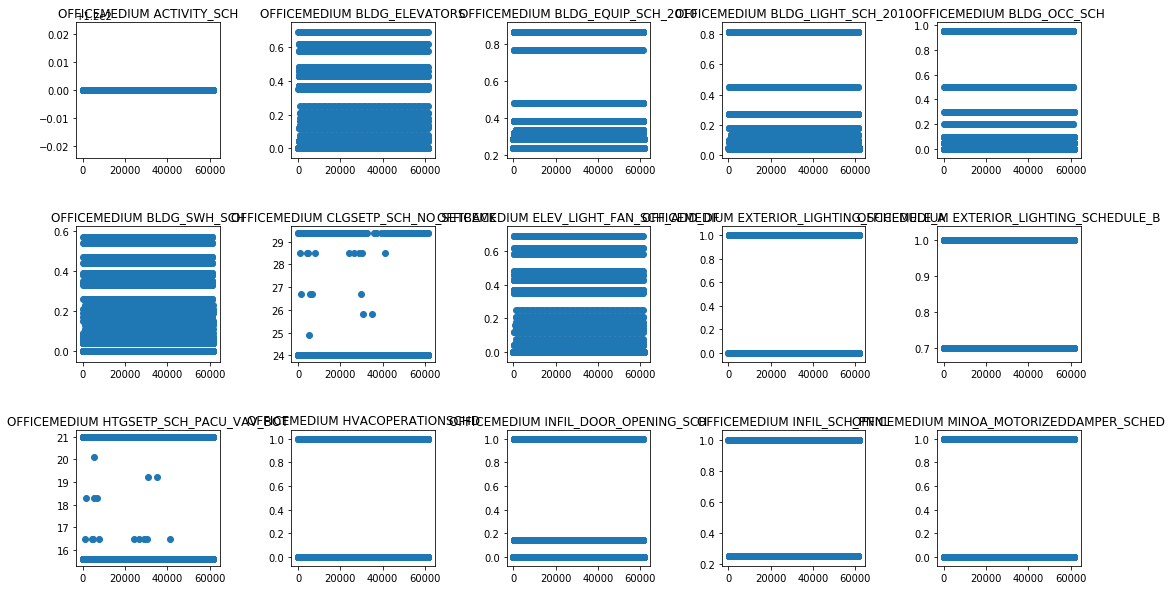

In [11]:
plot_columns(df_sched)

## Feature Engineering

In [15]:
# Feature Engineering
df_engr = df_mean.copy()

df_engr = df_engr.loc[:,~df_engr.columns.str.endswith('Zone Thermostat Control Type')]
df_engr = df_engr.loc[:,~df_engr.columns.str.endswith('People Air Temperature')]
df_engr = df_engr.loc[:,~df_engr.columns.str.endswith('Zone Predicted Sensible Load to Setpoint Heat Transfer Rate')]

In [16]:
# Let's normalize the entire dataframe
# Doing this over the entire data frame may not be the best but it's my first pass

standard_scaler = StandardScaler()
normalized_df = scale_data(df_engr, standard_scaler)
display(normalized_df.head())

,Cooling:Electricity,Electricity:Facility,ExteriorLights:Electricity,Fans:Electricity,Gas:Facility,Heating:Electricity,Heating:Gas,InteriorEquipment:Electricity,InteriorLights:Electricity,Pumps:Electricity,...,OFFICEMEDIUM BLDG_SWH_SCH,OFFICEMEDIUM CLGSETP_SCH_NO_SETBACK,OFFICEMEDIUM ELEV_LIGHT_FAN_SCH_ADD_DF,OFFICEMEDIUM EXTERIOR_LIGHTING_SCHEDULE_A,OFFICEMEDIUM EXTERIOR_LIGHTING_SCHEDULE_B,OFFICEMEDIUM HTGSETP_SCH_PACU_VAV_BOT,OFFICEMEDIUM HVACOPERATIONSCHD,OFFICEMEDIUM INFIL_DOOR_OPENING_SCH,OFFICEMEDIUM INFIL_SCH_PNNL,OFFICEMEDIUM MINOA_MOTORIZEDDAMPER_SCHED
0,-0.909441,-1.134919,0.57219,-1.195518,-0.317557,-0.384215,-0.010685,-0.923083,-0.796463,-1.471306,...,-0.932576,-0.176688,-0.755027,-1.732051,-1.732051,-1.106499,-1.096914,-0.472368,1.096914,-1.02123
1,-0.909441,-1.134919,0.57219,-1.195518,-0.317557,-0.384215,-0.010685,-0.923083,-0.796463,-1.471306,...,-0.932576,-0.176688,-0.755027,-1.732051,-1.732051,-1.106499,-1.096914,-0.472368,1.096914,-1.02123
2,-0.909441,-1.053571,0.57219,-0.922518,-0.317557,-0.259629,-0.010685,-0.923083,-0.796463,-1.471306,...,-0.932576,-0.176688,-0.755027,-1.732051,-1.732051,-1.106499,-1.096914,-0.472368,1.096914,-1.02123
3,-0.909441,-1.074897,0.57219,-0.968018,-0.317557,-0.295772,-0.010685,-0.923083,-0.796463,-1.471306,...,-0.932576,-0.176688,-0.755027,-1.732051,-1.732051,-1.106499,-1.096914,-0.472368,1.096914,-1.02123
4,-0.909441,-1.134919,0.57219,-1.195518,-0.317557,-0.384215,-0.010685,-0.923083,-0.796463,-1.471306,...,-0.932576,-0.176688,-0.755027,-1.732051,-1.732051,-1.106499,-1.096914,-0.472368,1.096914,-1.02123


In [17]:
# Filter out meter variables
X = normalized_df.drop([("Electricity:Facility"), ("Gas:Facility")], axis=1)
X = X.loc[:,~X.columns.str.endswith(':Electricity')]
X = X.loc[:,~X.columns.str.endswith(':Gas')]

y = normalized_df["Electricity:Facility"]

### Correlation

In [18]:
normalized_df[normalized_df.columns].corr()['Electricity:Facility'][:]

Cooling:Electricity                             0.649884
Electricity:Facility                            1.000000
ExteriorLights:Electricity                     -0.543202
Fans:Electricity                                0.877631
Gas:Facility                                    0.284978
Heating:Electricity                             0.432388
Heating:Gas                                    -0.011236
InteriorEquipment:Electricity                   0.821983
InteriorLights:Electricity                      0.820476
Pumps:Electricity                               0.684457
WaterSystems:Gas                                0.284995
Zone Air Humidity Ratio                        -0.097771
Zone Air Temperature                            0.037044
Zone Outdoor Air Drybulb Temperature            0.141125
Zone Outdoor Air Wetbulb Temperature            0.026423
Zone Outdoor Air Wind Speed                     0.188251
Zone People Occupant Count                      0.776922
Zone Thermostat Cooling Setpoin

## Linear Model Training & Results

In [19]:
model_lasso = LassoCV(cv=5).fit(X, y)

In [20]:
rmse_cv(model_lasso, X, y).mean()

0.4173280731599462

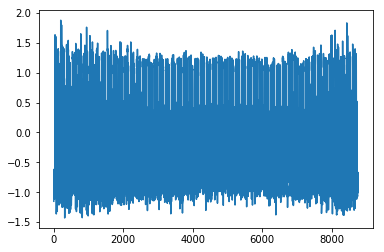

In [21]:
# Predictions on test dataset
# print("RMSE Error: {0}".format(rmse_cv(model_lasso).mean()))
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(X.index.values, model_lasso.predict(X))

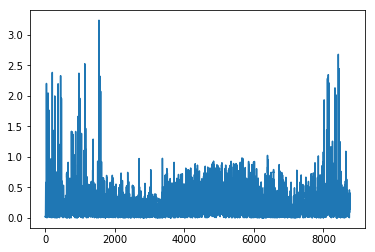

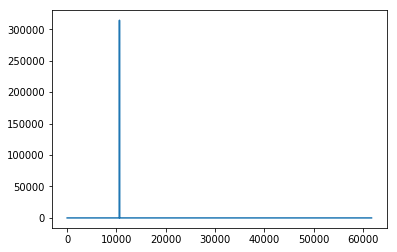

In [22]:
# Error in testing data
plt.plot(X.index.values, abs(y - model_lasso.predict(X)))
plt.show()

plt.plot(df_zone["Heating:Gas"])
plt.show()

Lasso picked 19 variables and eliminated the other 4 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

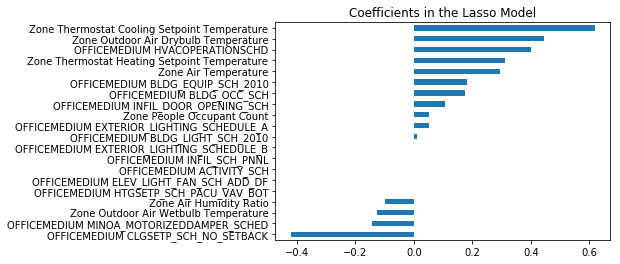

In [23]:
coef = pd.Series(model_lasso.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

## RNN Model Training and Results

In [ ]:

feaut
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))  

In [ ]:
# MLP with automatic validation set
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# create model
rnn_lstm_model = Sequential()
rnn_lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(len(X.index), len(X.columns))))  
rnn_lstm_model.add(Dropout(0.2)) 

rnn_lstm_model.add(LSTM(units=50, return_sequences=True))  
rnn_lstm_model.add(Dropout(0.2))

rnn_lstm_model.add(LSTM(units=50, return_sequences=True))  
rnn_lstm_model.add(Dropout(0.2))

rnn_lstm_model.add(LSTM(units=50))  
rnn_lstm_model.add(Dropout(0.2))  

rnn_lstm_model.add(Dense(units = 1))  

rnn_lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fit the model
rnn_lstm_model.fit(X, y, validation_split=0.33, epochs=150, batch_size=10)

In [ ]:
rmse_cv(model, X, y).mean()